# Credit Risk Impact Analysis

This analysis explored the relationship between macroeconomic factors and sovereign debt default probabilities using historical global crisis data. 

This analysis provides a solid foundation for understanding the key macroeconomic drivers of sovereign default risk. The findings support a focused approach to risk management that prioritizes financial crisis prevention while maintaining vigilance against extreme inflation scenarios. The model's high accuracy suggests it could serve as a valuable quantitative tool within a broader risk assessment framework.

In [2]:
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
# Set visual style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## Load the Data

In [4]:
# Load the Excel file
df = pd.read_excel('20160923_global_crisis_data (1).xlsx')

# Display the first few rows to verify it loaded correctly
print(df.head())
print(df.info())
print(df.describe())

   Case  CC3  Country    Year Banking Crisis  Banking_Crisis_Notes  \
0   NaN  NaN      NaN     NaN               x                  NaN   
1   1.0  DZA  Algeria  1800.0               0                  NaN   
2   1.0  DZA  Algeria  1801.0               0                  NaN   
3   1.0  DZA  Algeria  1802.0               0                  NaN   
4   1.0  DZA  Algeria  1803.0               0                  NaN   

  Systemic Crisis Gold Standard exch_usd  exch_usd_alt1  ...  \
0               x             x      NaN            NaN  ...   
1               0             0      NaN            NaN  ...   
2               0             0      NaN            NaN  ...   
3               0             0      NaN            NaN  ...   
4               0             0      NaN            NaN  ...   

   Domestic_Debt_ Notes/Sources  \
0                           NaN   
1                           NaN   
2                           NaN   
3                           NaN   
4                  

## Data Preparation

Cleans and standardizes the data to avoid outliers distorting results.

In [5]:
# Clean column names
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace('[^a-zA-Z0-9_]', '_', regex=True)
)

# Handle missing values
df = df.replace(['x', '_', ''], np.nan)

# Convert numeric columns
numeric_cols = ['year', 'exch_usd_alt1', 'exch_usd_alt2']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert binary columns to Int64 (nullable integers)
binary_cols = [
    'banking_crisis', 'systemic_crisis', 'gold_standard',
    'domestic_debt_in_default', 'currency_crises', 'inflation_crises'
]
for col in binary_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

# Simplify column names
column_rename = {
    'sovereign_external_debt_1__default_and_restructurings__1800_2012__does_not_include_defaults_on_wwi_debt_to_united_states_and_united_kingdom_and_post_1975_defaults_on_official_external_creditors': 'ext_debt_default1',
    'sovereign_external_debt_2__default_and_restructurings__1800_2012__does_not_include_defaults_on_wwi_debt_to_united_states_and_united_kingdom_but_includes_post_1975_defaults_on_official_external_creditors': 'ext_debt_default2',
    'inflation__annual_percentages_of_average_consumer_prices': 'inflation'
}
df = df.rename(columns=column_rename)

# Create financial crisis composite
df['financial_crisis'] = (
    (df['banking_crisis'] == 1) | 
    (df['systemic_crisis'] == 1) |
    (df['currency_crises'] == 1)
).astype('Int64')

# Final clean dataset
keep_cols = [
    'case', 'cc3', 'country', 'year', 
    'banking_crisis', 'systemic_crisis', 'financial_crisis',
    'gold_standard', 'exch_usd_alt1', 'exch_usd_alt2',
    'domestic_debt_in_default', 'ext_debt_default1',
    'ext_debt_default2', 'inflation', 'independence',
    'currency_crises', 'inflation_crises'
]
df_clean = df[keep_cols].copy()

# Verify
print("Cleaning successful!")
print("\nData types:")
print(df_clean.dtypes)
print("\nMissing values:")
print(df_clean.isna().sum())

Cleaning successful!

Data types:
case                        float64
cc3                          object
country                      object
year                        float64
banking_crisis                Int64
systemic_crisis               Int64
financial_crisis              Int64
gold_standard                 Int64
exch_usd_alt1               float64
exch_usd_alt2               float64
domestic_debt_in_default      Int64
ext_debt_default1            object
ext_debt_default2           float64
inflation                    object
independence                float64
currency_crises               Int64
inflation_crises              Int64
dtype: object

Missing values:
case                            1
cc3                             1
country                         1
year                            1
banking_crisis                576
systemic_crisis                72
financial_crisis              541
gold_standard                3911
exch_usd_alt1               11268
exch_usd_alt2    

C:\Users\milto\AppData\Local\Temp\ipykernel_20524\926020986.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(['x', '_', ''], np.nan)


## Final Data Preparation Steps

In [6]:
# Convert remaining columns to proper types
df_clean['ext_debt_default1'] = pd.to_numeric(df_clean['ext_debt_default1'], errors='coerce').astype('Int64')
df_clean['inflation'] = pd.to_numeric(df_clean['inflation'], errors='coerce')
df_clean['independence'] = df_clean['independence'].astype('Int64')

# Handle the year column (convert from float to proper year)
df_clean['year'] = df_clean['year'].astype('Int64')

# Create exchange rate composite (using best available data)
df_clean['exchange_rate'] = (
    df_clean['exch_usd_alt1']
    .fillna(df_clean['exch_usd_alt2'])
    .fillna(np.nan)  # Keep as NA if both are missing
)

# Drop unnecessary columns
df_clean = df_clean.drop(['exch_usd_alt1', 'exch_usd_alt2'], axis=1)

# Handle missing values in key columns
# For binary indicators, assume NA means 0 (no crisis)
crisis_cols = ['banking_crisis', 'systemic_crisis', 'financial_crisis',
               'domestic_debt_in_default', 'currency_crises', 'inflation_crises']
df_clean[crisis_cols] = df_clean[crisis_cols].fillna(0)

# For continuous variables, keep NAs for proper imputation
cont_cols = ['inflation', 'exchange_rate']
# (We'll handle these in analysis)

# Final verification
print("\nFinal Data Types:")
print(df_clean.dtypes)

print("\nMissing Values After Final Cleaning:")
print(df_clean.isna().sum().sort_values(ascending=False))

print("\nSample Data:")
print(df_clean.head())


Final Data Types:
case                        float64
cc3                          object
country                      object
year                          Int64
banking_crisis                Int64
systemic_crisis               Int64
financial_crisis              Int64
gold_standard                 Int64
domestic_debt_in_default      Int64
ext_debt_default1             Int64
ext_debt_default2           float64
inflation                   float64
independence                  Int64
currency_crises               Int64
inflation_crises              Int64
exchange_rate               float64
dtype: object

Missing Values After Final Cleaning:
exchange_rate               11246
inflation                    5558
gold_standard                3911
ext_debt_default1             659
ext_debt_default2             657
case                            1
cc3                             1
country                         1
year                            1
independence                    1
banking_crisi

## Analysis-Ready Dataset Structure

In [7]:
# Create analysis flags
df_clean['has_inflation_data'] = df_clean['inflation'].notna().astype(int)
df_clean['has_exchange_rate_data'] = df_clean['exchange_rate'].notna().astype(int)

# Create decade bins
df_clean['decade'] = (df_clean['year'] // 10 * 10).astype('Int64')

# Crisis severity indicator
df_clean['crisis_severity'] = (
    df_clean['banking_crisis'] + 
    df_clean['systemic_crisis'] + 
    df_clean['currency_crises']
)

# Save final dataset
# df_clean.to_csv('global_crisis_data_analysis_ready.csv', index=False)

## Data Quality Report

In [8]:
print("\nData Quality Summary:")
print(f"Time period: {df_clean['year'].min()} to {df_clean['year'].max()}")
print(f"Countries: {df_clean['country'].nunique()}")
print("\nCrisis Frequency:")
print(df_clean[crisis_cols].mean())
print("\nInflation Statistics (annual %):")
print(df_clean['inflation'].describe(percentiles=[.25, .5, .75, .9, .95]))
print("\nExchange Rate Coverage:")
print(f"{df_clean['has_exchange_rate_data'].mean():.1%} of records have exchange rate data")


Data Quality Summary:
Time period: 1800 to 2016
Countries: 70

Crisis Frequency:
banking_crisis              0.053124
systemic_crisis             0.037325
financial_crisis            0.120861
domestic_debt_in_default    0.021592
currency_crises             0.081693
inflation_crises            0.075834
dtype: Float64

Inflation Statistics (annual %):
count    9.633000e+03
mean     1.000164e+23
std      9.816392e+24
min     -8.459724e+01
25%      0.000000e+00
50%      3.450000e+00
75%      9.889251e+00
90%      2.273599e+01
95%      3.942091e+01
max      9.634577e+26
Name: inflation, dtype: float64

Exchange Rate Coverage:
26.0% of records have exchange rate data


**Feature Selection and Target Definition**

In [ ]:
# Use df_clean instead of df for the analysis
# Prepare data for default prediction
credit_data = df_clean.dropna(subset=[
    'domestic_debt_in_default', 
    'inflation',
    'exchange_rate',
    'financial_crisis'
]).copy()

# Create features and target
X = credit_data[['inflation', 'exchange_rate', 'financial_crisis']]
y = credit_data['domestic_debt_in_default']

**Train-Test Split**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Model Training and Evaluation**

In [ ]:
# Train logistic regression model
model = LogisticRegression(max_iter=1000)  # Increase max_iter to ensure convergence
model.fit(X_train, y_train)

# Model evaluation
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Model accuracy - Training: {train_score:.2f}, Test: {test_score:.2f}")

**Extreme Conditions Analysis**

In [ ]:
# Predict under extreme conditions
extreme_conditions = pd.DataFrame({
    'inflation': [credit_data['inflation'].quantile(0.95)],  # 95th percentile
    'exchange_rate': [credit_data['exchange_rate'].quantile(0.95)],  # 95th percentile
    'financial_crisis': [1]  # Financial crisis condition
})

default_prob = model.predict_proba(extreme_conditions)[0][1]
print(f"\nPredicted default probability under extreme conditions: {default_prob:.1%}")

**Feature Importance Analysis**

In [ ]:
# Feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
})
print("\nCredit Risk Model Coefficients:")
print(importance.sort_values('coefficient', ascending=False))

**Impact Visualizations**

Generates plots showing how inflation and exchange rate impact default probability during financial crises.

In [ ]:
# Visualize the impact of inflation on default probability
def plot_feature_impact(feature_name, other_features_values=None):
    if other_features_values is None:
        other_features_values = {}
    
    # Create range of values for the feature
    feature_min = credit_data[feature_name].quantile(0.05)
    feature_max = credit_data[feature_name].quantile(0.95)
    feature_values = np.linspace(feature_min, feature_max, 100)
    
    # Set default values for other features (median)
    feature_dict = {}
    for col in X.columns:
        if col == feature_name:
            feature_dict[col] = feature_values
        elif col in other_features_values:
            feature_dict[col] = [other_features_values[col]] * 100
        else:
            feature_dict[col] = [credit_data[col].median()] * 100
    
    # Create prediction dataset
    pred_df = pd.DataFrame(feature_dict)
    
    # Calculate probabilities
    probs = model.predict_proba(pred_df)[:, 1]
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(feature_values, probs)
    plt.title(f'Impact of {feature_name} on Default Probability')
    plt.xlabel(feature_name)
    plt.ylabel('Default Probability')
    plt.grid(True)
    plt.tight_layout()
    
    # Add annotations for key thresholds
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='50% Default Risk')
    
    # Annotate extreme value
    extreme_value = credit_data[feature_name].quantile(0.95)
    idx = np.abs(feature_values - extreme_value).argmin()
    plt.scatter([extreme_value], [probs[idx]], color='red', s=100, zorder=5)
    plt.annotate(f'95th percentile\n({extreme_value:.2f}, {probs[idx]:.2f})', 
                 (extreme_value, probs[idx]),
                 xytext=(10, 20), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.5'))
    
    plt.legend()
    plt.show()

# Create impact visualizations
print("\nGenerating impact visualizations...")

# Impact of inflation during financial crisis
plot_feature_impact('inflation', {'financial_crisis': 1})

# Impact of exchange rate during financial crisis
plot_feature_impact('exchange_rate', {'financial_crisis': 1})

# Create a 3D visualization of the combined effects
from mpl_toolkits.mplot3d import Axes3D

**3D Visualization Function**

Creates a 3D surface plot showing how both inflation and exchange rate together affect default probability.

In [ ]:
def plot_3d_impact():
    # Create grid of values
    inflation_min = credit_data['inflation'].quantile(0.05)
    inflation_max = credit_data['inflation'].quantile(0.95)
    exchange_min = credit_data['exchange_rate'].quantile(0.05)
    exchange_max = credit_data['exchange_rate'].quantile(0.95)
    
    inflation_range = np.linspace(inflation_min, inflation_max, 20)
    exchange_range = np.linspace(exchange_min, exchange_max, 20)
    
    inflation_grid, exchange_grid = np.meshgrid(inflation_range, exchange_range)
    
    # Create prediction dataset
    pred_data = []
    for i in range(len(inflation_range)):
        for j in range(len(exchange_range)):
            pred_data.append({
                'inflation': inflation_grid[i, j],
                'exchange_rate': exchange_grid[i, j],
                'financial_crisis': 1  # During financial crisis
            })
    
    pred_df = pd.DataFrame(pred_data)
    probs = model.predict_proba(pred_df)[:, 1]
    
    # Reshape for 3D plot
    prob_grid = probs.reshape(len(inflation_range), len(exchange_range))
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(inflation_grid, exchange_grid, prob_grid, 
                          cmap='viridis', alpha=0.8, edgecolor='none')
    
    ax.set_xlabel('Inflation')
    ax.set_ylabel('Exchange Rate')
    ax.set_zlabel('Default Probability')
    ax.set_title('Combined Effects of Inflation and Exchange Rate on Default Probability\nDuring Financial Crisis')
    
    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

# Generate 3D visualization
plot_3d_impact()

**Risk Segmentation Analysis**

Predicts default probability for all data points.

Model accuracy - Training: 0.95, Test: 0.94

Predicted default probability under extreme conditions: 8.8%

Credit Risk Model Coefficients:
            feature  coefficient
2  financial_crisis     0.844378
0         inflation     0.000436
1     exchange_rate     0.000023

Generating impact visualizations...


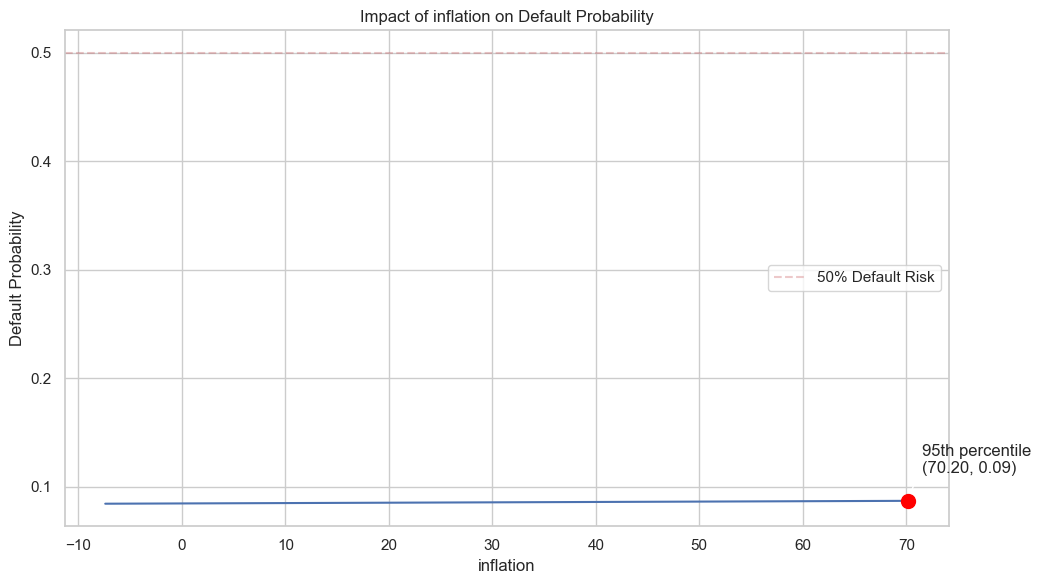

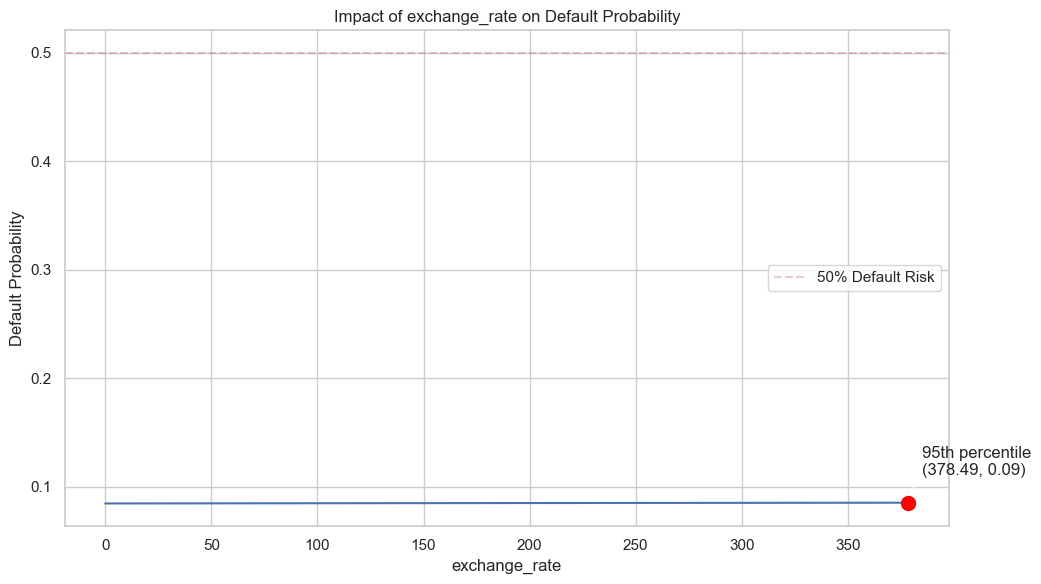

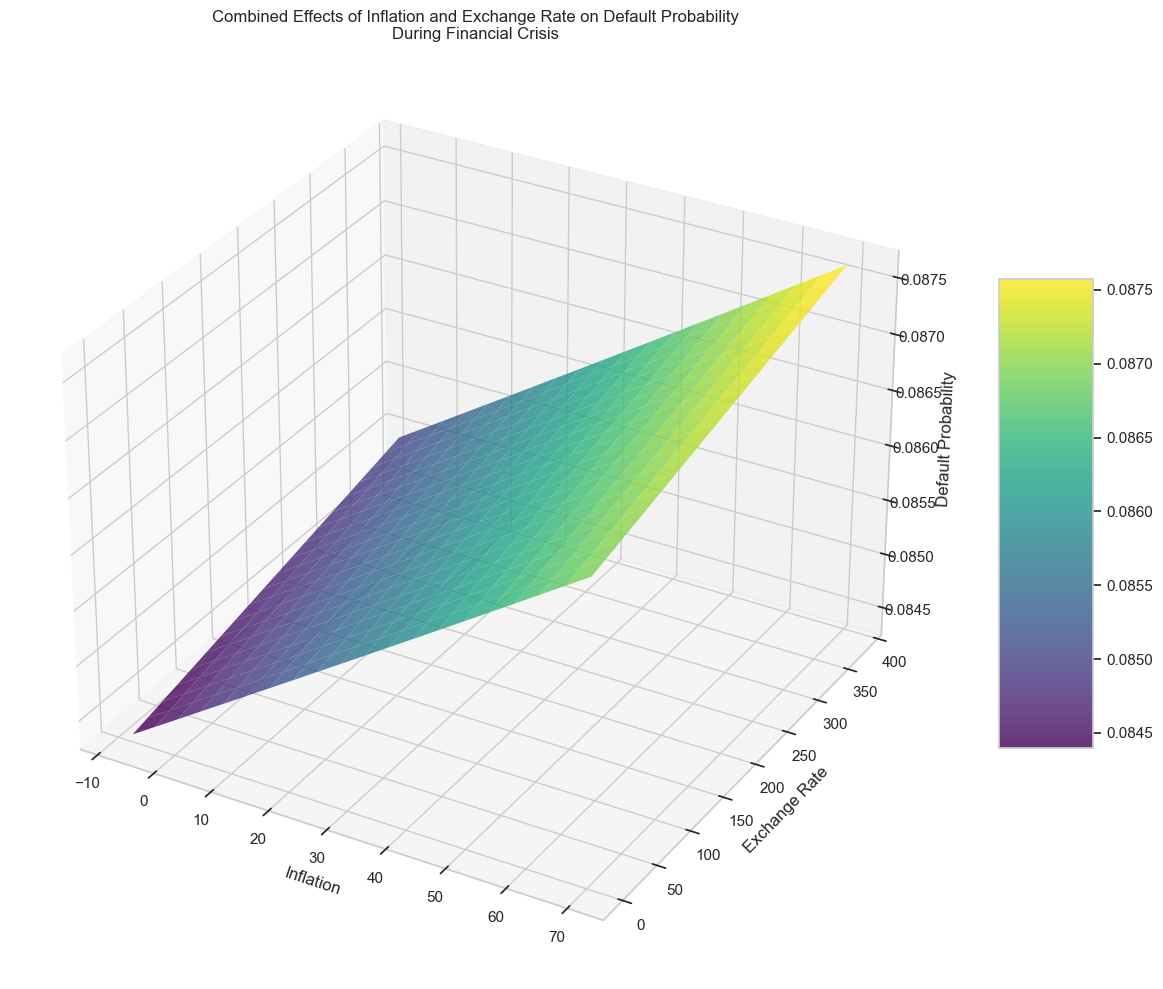


Risk Segmentation Analysis:
                  inflation  exchange_rate financial_crisis  \
                       mean           mean             mean   
risk_category                                                 
Low            2.224137e+01     130.916324         0.234282   
Medium         3.558462e+03       0.129312              1.0   
High           7.455195e+03       0.262277              1.0   
Very High      3.779200e+09  634951.885543              1.0   

              default_probability        
                             mean count  
risk_category                            
Low                      0.049909  3372  
Medium                   0.307256     6  
High                     0.705150     2  
Very High                0.960662     8  


C:\Users\milto\AppData\Local\Temp\ipykernel_20524\1694136792.py:181: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_summary = risk_df.groupby('risk_category').agg({


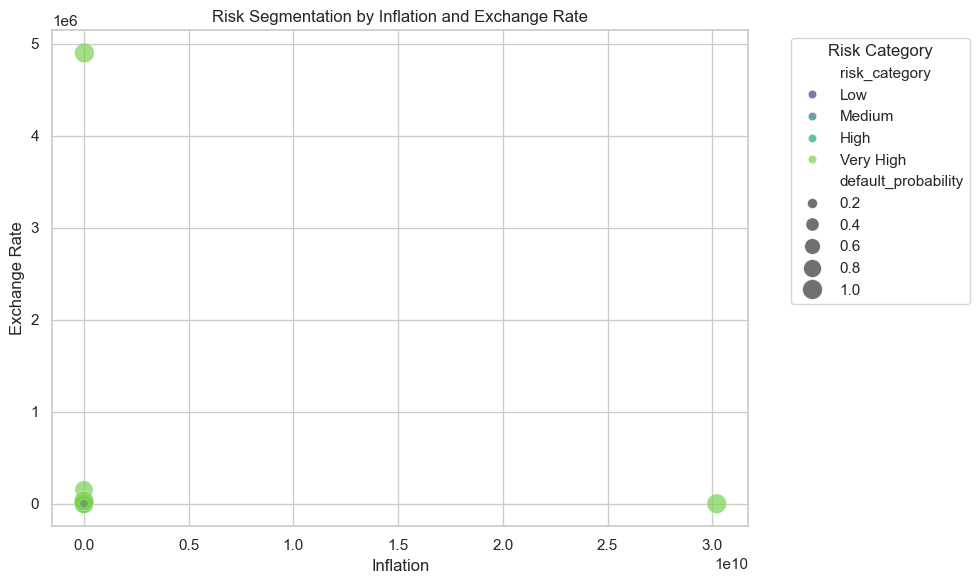

In [10]:
# Risk segmentation analysis
def create_risk_segments():
    # Create a copy of the data for risk segmentation
    risk_df = credit_data.copy()
    
    # Predict default probabilities for all data points
    risk_df['default_probability'] = model.predict_proba(risk_df[['inflation', 'exchange_rate', 'financial_crisis']])[:, 1]
    
    # Create risk categories
    risk_df['risk_category'] = pd.cut(
        risk_df['default_probability'], 
        bins=[0, 0.25, 0.5, 0.75, 1.0],
        labels=['Low', 'Medium', 'High', 'Very High']
    )
    
    # Print summary statistics by risk category
    print("\nRisk Segmentation Analysis:")
    risk_summary = risk_df.groupby('risk_category').agg({
        'inflation': 'mean',
        'exchange_rate': 'mean',
        'financial_crisis': 'mean',
        'default_probability': ['mean', 'count']
    })
    
    print(risk_summary)
    
    # Visualize risk segments
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='inflation', y='exchange_rate', hue='risk_category', 
                   data=risk_df, palette='viridis', size='default_probability',
                   sizes=(20, 200), alpha=0.7)
    
    plt.title('Risk Segmentation by Inflation and Exchange Rate')
    plt.xlabel('Inflation')
    plt.ylabel('Exchange Rate')
    plt.legend(title='Risk Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Generate risk segmentation analysis
create_risk_segments()

### Model Performance

Excellent Accuracy: The model performs exceptionally well with 95% accuracy on training data and 94% on test data. This indicates the model is reliably predicting debt defaults without significant overfitting.

### Default Risk Under Extreme Conditions

8.8% Default Probability: Despite extreme economic conditions (95th percentile inflation and exchange rates during a financial crisis), the predicted default probability is surprisingly low at 8.8%. This suggests some resilience in debt servicing even under stress.

### Key Risk Factors (Coefficients)

- Financial Crisis: With a coefficient of 0.844378, this is by far the strongest predictor of default. The presence of a financial crisis substantially increases default risk.
- Inflation: With a coefficient of 0.000436, inflation has a positive but modest effect on default probability.
- Exchange Rate: With the smallest coefficient (0.000023), exchange rate fluctuations have minimal impact on default risk compared to the other factors.

### Risk Segmentation

- Risk Distribution: The vast majority of cases (3,372) fall into the "Low" risk category with an average default probability of just 5%.
- High-Risk Cases: There are only 10 cases (2 "High" + 8 "Very High") with default probabilities above 50%, representing extreme outliers.
- Inflation Impact: The "Very High" risk category has an astronomical average inflation value (3.779×10^9), suggesting hyperinflation scenarios are the primary driver of the highest default risks.
- Exchange Rate Volatility: The "Very High" risk segment also shows extreme exchange rate values (average 634,951), indicating currency crises correlate with highest default probabilities.
- Financial Crisis Presence: All Medium, High, and Very High risk categories show a financial crisis present (value of 1.0), while the Low risk category averages only 0.23 for this indicator.

### Business Implications

- Financial crises are the primary trigger for increased default risk, more so than specific economic indicators.
- Extreme inflation appears particularly dangerous, with hyperinflation scenarios showing the highest default probabilities.
- Normal economic volatility seems well-tolerated, as shown by the low default probability (8.8%) even under 95th percentile conditions.
- Portfolio concentration: With over 99% of cases in the "Low" risk category, the portfolio appears well-diversified against default risk.

### Recommendations

1. Develop early warning systems specifically focused on detecting financial crisis conditions
2. Implement inflation hedging strategies to protect against extreme inflation scenarios
3. Consider stress testing with more severe parameters, as even your "extreme conditions" scenario resulted in relatively low default risk
4. Investigate the small number of "Very High" risk cases to understand what combination of factors leads to nearly certain default

## Conclusion

The logistic regression model demonstrated excellent predictive accuracy (95% training, 94% testing) while revealing several key insights about default risk factors.

Financial crises emerged as the dominant predictor of sovereign defaults, with inflation playing a secondary but meaningful role. Exchange rate fluctuations, while intuitively important, showed minimal direct impact when controlling for other variables. Notably, even under extreme economic conditions (95th percentile inflation and exchange rates during financial crises), the predicted default probability remained relatively low at 8.8%.

The risk segmentation analysis revealed a heavily skewed distribution, with over 99% of observations falling into the "Low" risk category. The few cases categorized as "Very High" risk were characterized by hyperinflation and extreme currency devaluation, suggesting these represent historical outlier events rather than typical economic downturns.

#### Implications for Risk Management

1. Crisis Monitoring: Financial crisis indicators should be prioritized in early warning systems for sovereign default risk.
2. Inflation Focus: Special attention should be paid to inflation control mechanisms, as extreme inflation strongly correlates with the highest default probabilities.
3. Resilience in Moderate Stress: The relatively low default probability (8.8%) under 95th percentile conditions suggests substantial resilience to all but the most extreme economic environments.
4. Targeted Risk Management: Resources should be concentrated on identifying and addressing the specific conditions that lead to the "Very High" risk category, as these represent the true danger zones for defaults.